In [1]:
import zabbix_db as zb
import pandas as pd
from adtk.detector import LevelShiftAD
import matplotlib.pyplot as plt

In [2]:
db_config = {
    'db_type': 'mysql',  # or 'postgresql'
    'host': '140.238.230.93',
    'port': 3306,  # 5432 for PostgreSQL
    'database': 'zabbix',
    'user': 'kartik',
    'password': 'Kartik@24082003'
}

# Sample hostname to query
hostname = 'Zabbix server'
metric_name = 'CPU utilization'  # Example metric name
# metric_name = 'Host name of Zabbix agent running'


with zb.ZabbixDB(**db_config) as zbx:
    result = zbx.get_metric_data(
        hostname=hostname,
        metric_name=metric_name,
        time_from=1746793913,  # Example start time (Unix timestamp)
        time_to=1749472314,  # Example end time (Unix timestamp)
          # Example statistical measure
    )
    print(result)


    # result = zbx.get_host_by_metric(metric_name=metric_name,time_from=1749032410, time_to=1749118810, statistical_measure='max')
    # # result = zbx.get_item_detail(item_name='CPU nice time', hostname=hostname)
    # print(result)

{'status': 'success', 'hostname': 'Zabbix server', 'metric_name': 'CPU utilization', 'unit': '%', 'data': [{'clock': 1749472284, 'value': 98.385677}, {'clock': 1749472224, 'value': 98.193099}, {'clock': 1749472164, 'value': 98.293716}, {'clock': 1749472104, 'value': 94.299715}, {'clock': 1749472044, 'value': 35.236254}, {'clock': 1749471984, 'value': 61.023937}, {'clock': 1749471924, 'value': 86.860485}, {'clock': 1749471864, 'value': 87.467418}, {'clock': 1749471804, 'value': 67.51037199999999}, {'clock': 1749471744, 'value': 94.290759}, {'clock': 1749471684, 'value': 97.394192}, {'clock': 1749471624, 'value': 97.235178}, {'clock': 1749471564, 'value': 97.516466}, {'clock': 1749471504, 'value': 93.163899}, {'clock': 1749471444, 'value': 33.539249999999996}, {'clock': 1749471384, 'value': 67.962963}, {'clock': 1749471324, 'value': 86.158121}, {'clock': 1749471264, 'value': 86.499327}, {'clock': 1749471204, 'value': 70.857814}, {'clock': 1749471144, 'value': 94.376076}, {'clock': 174947

In [3]:
data = pd.DataFrame(result['data'], columns=['clock', 'value'])
print(data)
data1 = data

            clock      value
0      1749472284  98.385677
1      1749472224  98.193099
2      1749472164  98.293716
3      1749472104  94.299715
4      1749472044  35.236254
...           ...        ...
45378  1746810000  79.781170
45379  1746806400  79.930848
45380  1746802800  80.246104
45381  1746799200  80.479468
45382  1746795600  80.350362

[45383 rows x 2 columns]


In [4]:
# # Convert 'clock' from Unix timestamp to datetime and set as index
# data['timestamp'] = pd.to_datetime(data['clock'], unit='s')
# data_series = data.set_index('timestamp')['value']

# # Initialize the LevelShiftAD detector
# model = LevelShiftAD(c=1.5, side='both', window=5)

# # Detect anomalies
# anomalies = model.fit_detect(data_series)

# # Extract timestamps and values where anomalies are found
# anomaly_timestamps = anomalies[anomalies == 1].index
# anomaly_values = data_series.loc[anomaly_timestamps]

# # Create a DataFrame with anomalies
# anomaly_df = pd.DataFrame({'timestamp': anomaly_timestamps, 'value': anomaly_values})

# # Save anomalies to CSV
# anomaly_df.to_csv('anomalies.csv', index=False)
# print("Anomalies saved to anomalies.csv")

# # Visualize the data with anomalies
# plt.figure(figsize=(12, 6))
# plt.plot(data_series.index, data_series, label='Data', color='#36A2EB')
# plt.scatter(anomaly_timestamps, anomaly_values, color='#FF6384', label='Anomalies')
# plt.xlabel('Timestamp')
# plt.ylabel('Value (e.g., CPU Utilization)')
# plt.title('Anomaly Detection in IT Monitoring Data')
# plt.legend()
# plt.show()

In [5]:
df = data

     clock      value
0        0  62.607927
103      0  48.805174
104      0  66.064375
105      0  41.599462
106      0  47.757056
..     ...        ...
56       0  60.233057
57       0  65.251420
58       0  58.215607
40       0  70.579570
161      0  80.977600

[162 rows x 2 columns]


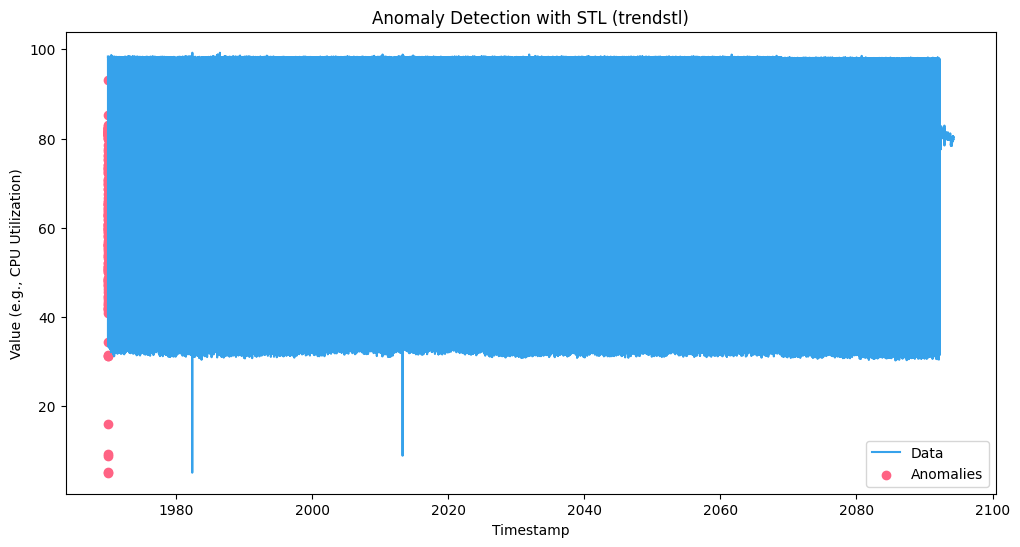

In [6]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Ensure df is sorted by index (which is already datetime 'clock')
df = df.sort_index()

# Perform STL decomposition
stl = STL(
    df['value'],
    period=60,      # Hourly seasonality (60 minutes)
    seasonal=7,     # Seasonal smoother length
    trend=121,      # Trend smoother length
    robust=True
)
decomposition = stl.fit()

# Extract residual and calculate standard deviation
residual = decomposition.resid
std_resid = residual.std()

# Set anomaly threshold (3 deviations)
anomaly_threshold = 5 * std_resid

# Find anomalies where |residual| > threshold
anomaly_indices = residual[abs(residual) > anomaly_threshold].index

# Create output DataFrame with 'clock' (Unix timestamps) and 'value'
anomalies = pd.DataFrame({
    'clock': (anomaly_indices.astype(int) // 10**9).astype(int),
    'value': df['value'].loc[anomaly_indices]
}, index=anomaly_indices)

# Reset index to remove 'clock' as an index, keeping it only as a column
anomalies = anomalies.reset_index(drop=True)

# Sort by 'clock' for clarity
anomalies = anomalies.sort_values('clock')

# Print the anomalies DataFrame
print(anomalies)

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], label='Data', color='#36A2EB')
plt.scatter(anomalies['clock'].apply(lambda x: pd.Timestamp(x, unit='s')), anomalies['value'], color='#FF6384', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Value (e.g., CPU Utilization)')
plt.title('Anomaly Detection with STL (trendstl)')
plt.legend()
plt.show()

In [35]:
df=data1
df.head()

,value
clock,
2025-06-09 12:31:24,98.385677
2025-06-09 12:30:24,98.193099
2025-06-09 12:29:24,98.293716
2025-06-09 12:28:24,94.299715
2025-06-09 12:27:24,35.236254


/tmp/ipykernel_681611/1594044350.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('1T')  # 1-minute data; adjust if needed



Detected Anomalies (Last 1 Hour, Pattern-Filtered):
Empty DataFrame
Columns: [clock, value]
Index: []


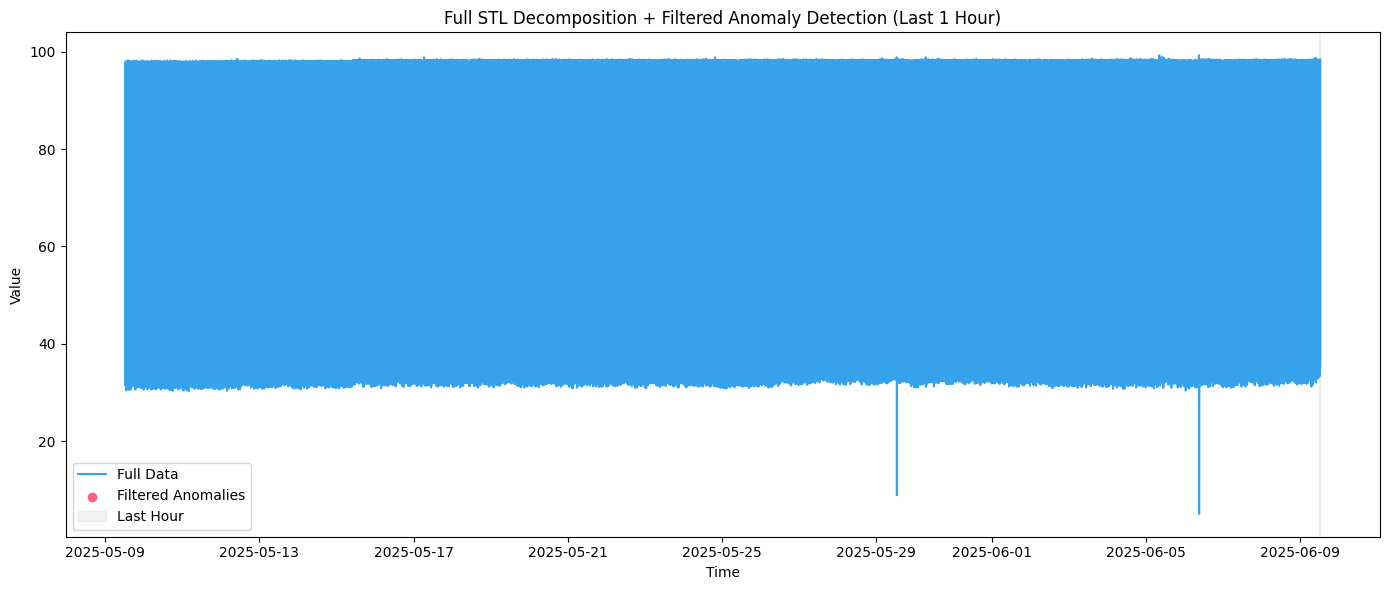

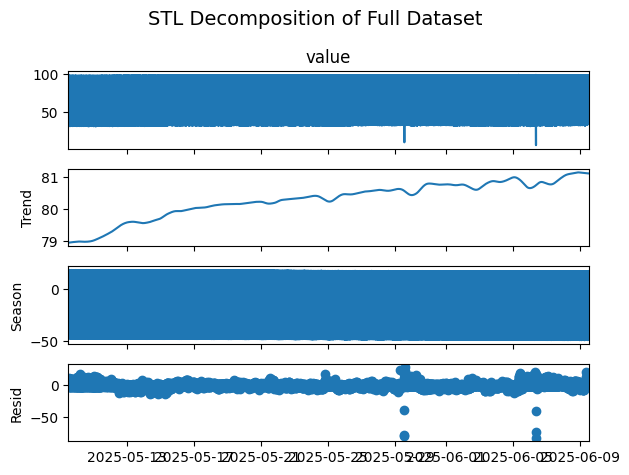

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.robust import mad

# --- Step 1: Preprocess Full Data ---
# Assume df has datetime index and 'value' column

df = df.sort_index()
df = df.asfreq('1T')  # 1-minute data; adjust if needed
df['value'] = df['value'].interpolate(method='time')

# --- Step 2: STL Decomposition on Full Dataset ---
period = 1440        # 1 day (for 1-min data)
seasonal = 61
trend = 1921         # Must be > period and odd

stl = STL(df['value'], period=period, seasonal=seasonal, trend=trend, robust=True)
result = stl.fit()

resid = result.resid
threshold = 5 * mad(resid)

# --- Step 3: Get Last 1-Hour Residuals ---
last_hour_start = df.index.max() - pd.Timedelta(hours=1)
last_hour_resid = resid[last_hour_start:]

# --- Step 4: Pattern Check (Smart Suppression of Common Behavior) ---
def is_repeating_pattern(ts_index, df, tolerance=0.1):
    """
    Checks whether a similar value occurred often historically around the same time of day.
    Suppresses anomaly if it is part of a repeating pattern.
    """
    matches = 0
    current_value = df.loc[ts_index, 'value']
    time_of_day = ts_index.time()
    
    # Create a time window of +/- 3 minutes around that time of day for historical days
    for day_offset in range(1, 31):  # last 30 days
        try:
            compare_time = ts_index - pd.Timedelta(days=day_offset)
            compare_window = df.between_time(
                (pd.Timestamp.combine(compare_time.date(), time_of_day) - pd.Timedelta(minutes=3)).time(),
                (pd.Timestamp.combine(compare_time.date(), time_of_day) + pd.Timedelta(minutes=3)).time()
            )

            if not compare_window.empty:
                if np.any(abs(compare_window['value'] - current_value) < tolerance * current_value):
                    matches += 1
        except:
            continue

    return matches >= 2  # suppress if value occurs >=2 times historically

# --- Step 5: Identify True Anomalies (Filter Repeating Patterns) ---
anomalies = []
for ts in last_hour_resid.index:
    if abs(last_hour_resid.loc[ts]) > threshold:
        if not is_repeating_pattern(ts, df):
            anomalies.append((ts, df.loc[ts, 'value']))

# --- Step 6: Format Anomalies as DataFrame ---
anomaly_df = pd.DataFrame(anomalies, columns=['timestamp', 'value'])
anomaly_df['clock'] = anomaly_df['timestamp'].astype(np.int64) // 10**9
anomaly_df = anomaly_df[['clock', 'value']]

print("\nDetected Anomalies (Last 1 Hour, Pattern-Filtered):")
print(anomaly_df)

# --- Step 7: Plot Full Data + Anomalies ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['value'], label='Full Data', color='#36A2EB')
plt.scatter(
    anomaly_df['clock'].apply(lambda x: pd.to_datetime(x, unit='s')),
    anomaly_df['value'],
    color='#FF6384', label='Filtered Anomalies'
)
plt.axvspan(last_hour_start, df.index.max(), color='gray', alpha=0.1, label='Last Hour')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Full STL Decomposition + Filtered Anomaly Detection (Last 1 Hour)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 8: STL Components Plot (Optional) ---
result.plot()
plt.suptitle('STL Decomposition of Full Dataset', fontsize=14)
plt.tight_layout()
plt.show()


/tmp/ipykernel_681611/1350331308.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('1T')  # 1-min frequency
/tmp/ipykernel_681611/1350331308.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_recent_merged['median'].fillna(df_historic['value'].median(), inplace=True)
/tmp/ipykernel_681611/1350331308.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior wil


Detected Anomalies (Last 1 Hour, Optimized): 0 anomalies
Empty DataFrame
Columns: [clock, value]
Index: []


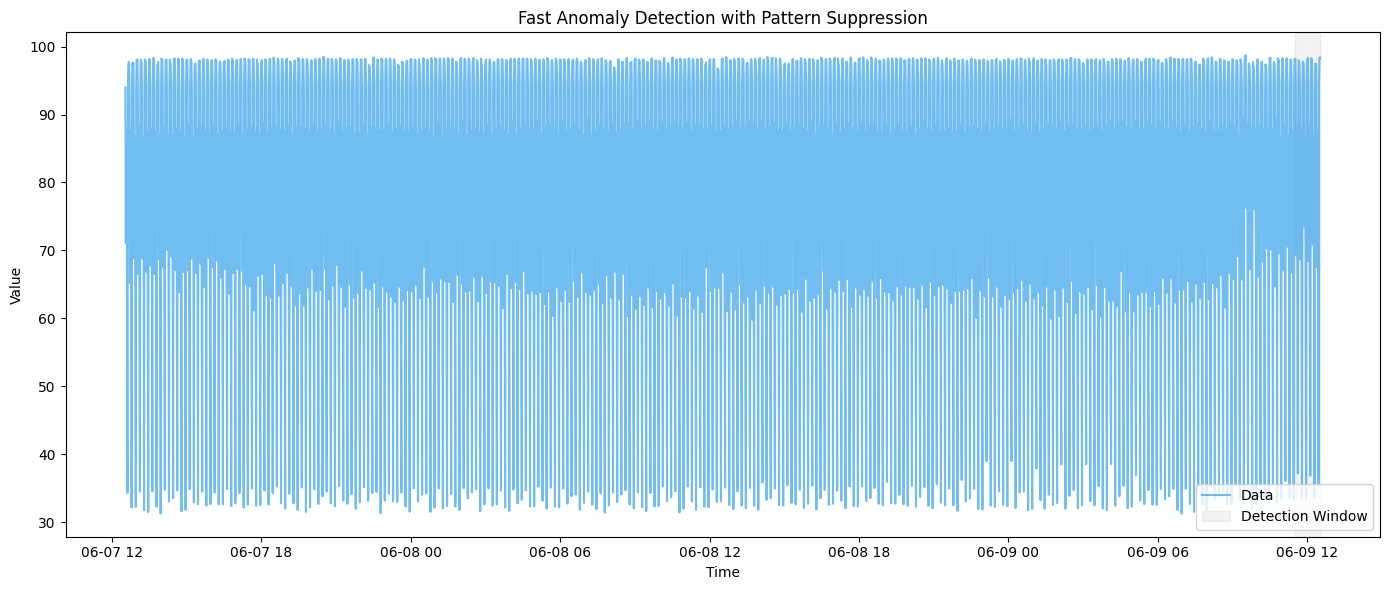


Processing summary:
Historical data points: 44,579
Recent data points: 61
Unique minute patterns: 1,440


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.robust import mad

# --- Load & preprocess ---
df = df.sort_index()
df = df.asfreq('1T')  # 1-min frequency
df['value'] = df['value'].interpolate(method='time')

# --- Extract last 1-hour window first ---
now = df.index.max()
last_hour_start = now - pd.Timedelta(hours=1)

# Split data: historical for pattern learning, recent for anomaly detection
df_historic = df.loc[df.index < last_hour_start].copy()
df_recent = df.loc[df.index >= last_hour_start].copy()

# --- Quick STL on recent data only (much faster) ---
if len(df_recent) >= 60:  # Need minimum points for STL
    period = min(60, len(df_recent) // 2)  # Adaptive period for short sequences
    stl_recent = STL(df_recent['value'], period=period, seasonal=7, trend=None, robust=True)
    res_recent = stl_recent.fit()
    resid_recent = res_recent.resid
else:
    # Fallback: simple detrending for very short sequences
    resid_recent = df_recent['value'] - df_recent['value'].rolling(window=5, center=True).mean()

# --- Vectorized pattern analysis ---
df_historic['minute'] = df_historic.index.hour * 60 + df_historic.index.minute
df_recent['minute'] = df_recent.index.hour * 60 + df_recent.index.minute

# Precompute historical stats (vectorized)
stats = df_historic.groupby('minute')['value'].agg(['median', mad]).rename(columns={'mad': 'mad_val'})

# --- Vectorized anomaly detection ---
# Global threshold from recent residuals
global_thresh = 3 * mad(resid_recent.dropna())

# Merge recent data with historical stats
df_recent_merged = df_recent.merge(stats, left_on='minute', right_index=True, how='left')

# Fill missing stats with global median/mad for minutes not in historical data
df_recent_merged['median'].fillna(df_historic['value'].median(), inplace=True)
df_recent_merged['mad_val'].fillna(mad(df_historic['value']), inplace=True)

# Vectorized anomaly conditions
resid_condition = np.abs(resid_recent) > global_thresh
pattern_condition = np.abs(df_recent_merged['value'] - df_recent_merged['median']) > 2.5 * df_recent_merged['mad_val']

# Combine conditions
anomaly_mask = resid_condition & pattern_condition

# Extract anomalies
anomaly_timestamps = df_recent.index[anomaly_mask]
anomaly_values = df_recent['value'][anomaly_mask]

# --- Create output DataFrame ---
if len(anomaly_timestamps) > 0:
    anomaly_df = pd.DataFrame({
        'timestamp': anomaly_timestamps,
        'value': anomaly_values
    })
    anomaly_df['clock'] = anomaly_df['timestamp'].astype(np.int64) // 10**9
    anomaly_df = anomaly_df[['clock', 'value']]
else:
    anomaly_df = pd.DataFrame(columns=['clock', 'value'])

print(f"\nDetected Anomalies (Last 1 Hour, Optimized): {len(anomaly_df)} anomalies")
print(anomaly_df)

# --- Optimized Plot ---
plt.figure(figsize=(14, 6))

# Plot only recent data for speed (or sample historical data)
recent_plot_data = df.tail(2880) if len(df) > 2880 else df  # Last 2 days max
plt.plot(recent_plot_data.index, recent_plot_data['value'], label='Data', color='#36A2EB', alpha=0.7)

if len(anomaly_df) > 0:
    plt.scatter(
        pd.to_datetime(anomaly_df['clock'], unit='s'),
        anomaly_df['value'], 
        color='#FF6384', 
        label=f'Anomalies ({len(anomaly_df)})',
        s=50, 
        zorder=5
    )

plt.axvspan(last_hour_start, now, color='gray', alpha=0.1, label='Detection Window')
plt.title('Fast Anomaly Detection with Pattern Suppression')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# --- Performance info ---
print(f"\nProcessing summary:")
print(f"Historical data points: {len(df_historic):,}")
print(f"Recent data points: {len(df_recent):,}")
print(f"Unique minute patterns: {len(stats):,}")

/tmp/ipykernel_681611/3808769672.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('1T')  # 1-min frequency


Processing 44,640 data points...
Large dataset detected, using chunked processing...
Processing chunk 1/31...
STL failed for chunk 1, using simple detrending: trend must be an odd positive integer >= 3 where trend > period
Processing chunk 2/31...
STL failed for chunk 2, using simple detrending: trend must be an odd positive integer >= 3 where trend > period
Processing chunk 3/31...
STL failed for chunk 3, using simple detrending: trend must be an odd positive integer >= 3 where trend > period
Processing chunk 4/31...
STL failed for chunk 4, using simple detrending: trend must be an odd positive integer >= 3 where trend > period
Processing chunk 5/31...
STL failed for chunk 5, using simple detrending: trend must be an odd positive integer >= 3 where trend > period
Processing chunk 6/31...
STL failed for chunk 6, using simple detrending: trend must be an odd positive integer >= 3 where trend > period
Processing chunk 7/31...
STL failed for chunk 7, using simple detrending: trend must be

/tmp/ipykernel_681611/3808769672.py:134: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['median'].fillna(global_median, inplace=True)
/tmp/ipykernel_681611/3808769672.py:135: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

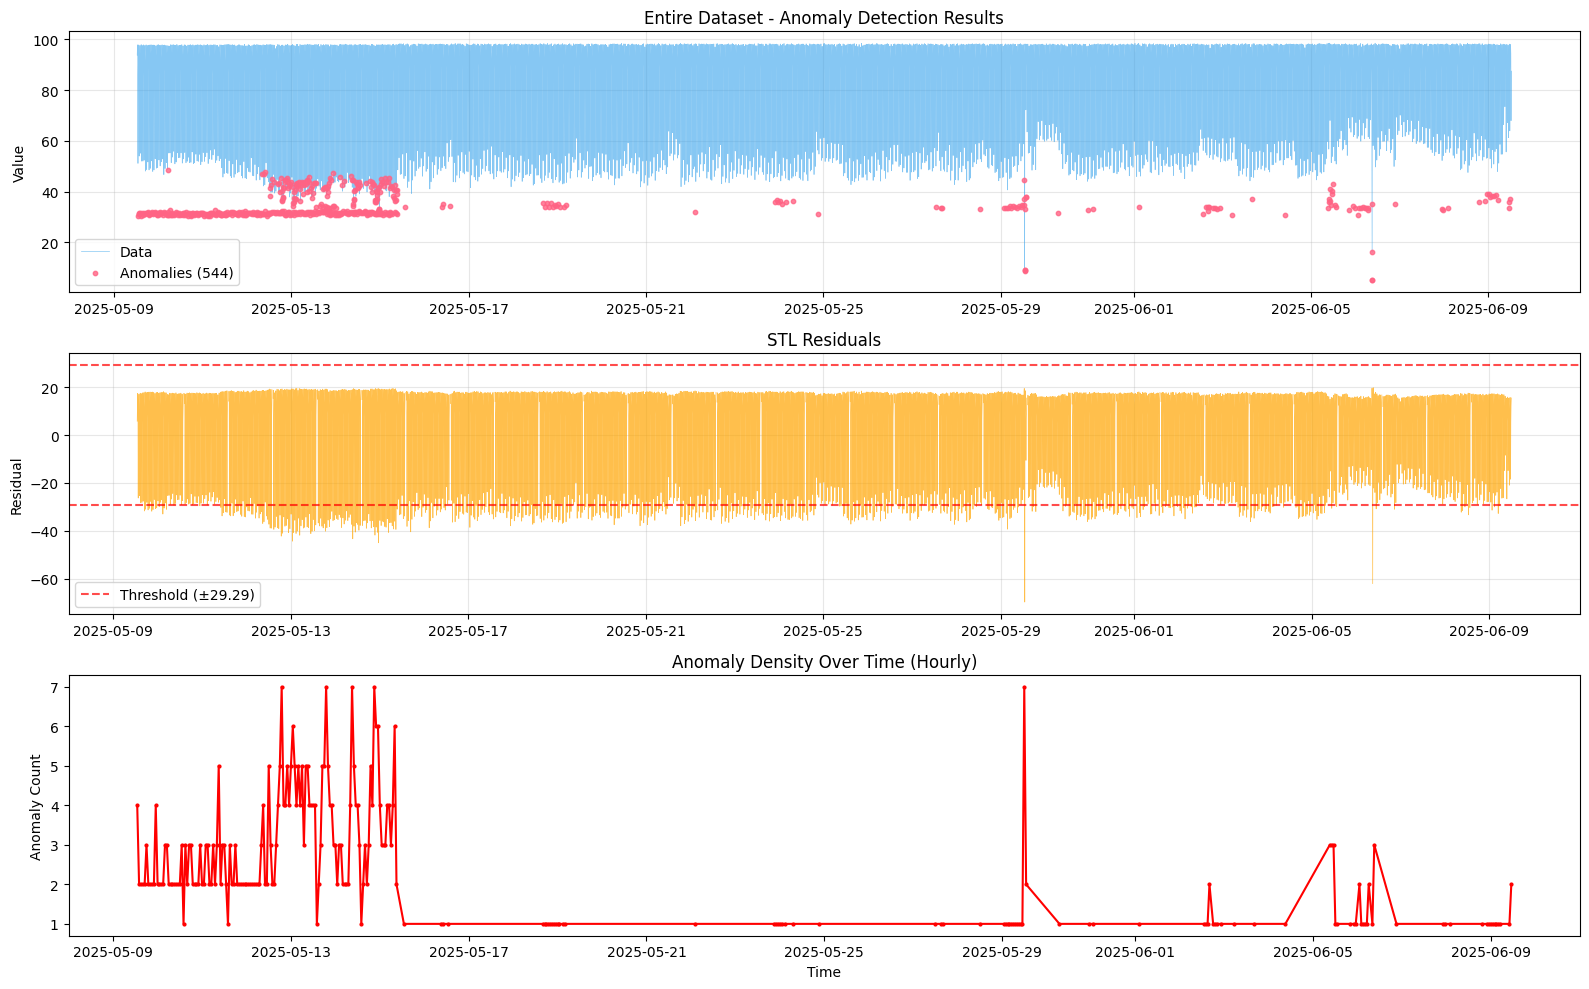


ANOMALY DETECTION SUMMARY
Total data points processed: 44,640
Total anomalies detected: 544
Anomaly rate: 1.219%
Global residual threshold: 29.288
Processing completed successfully!


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.robust import mad

# --- Load & preprocess ---
df = df.sort_index()
df = df.asfreq('1T')  # 1-min frequency
df['value'] = df['value'].interpolate(method='time')

print(f"Processing {len(df):,} data points...")

# --- Strategy: Chunked STL processing for large datasets ---
def chunked_stl_decomposition(data, chunk_size_hours=24, overlap_hours=2):
    """
    Process STL in overlapping chunks to handle large datasets efficiently
    """
    chunk_size = chunk_size_hours * 60  # Convert to minutes
    overlap_size = overlap_hours * 60
    residuals = pd.Series(index=data.index, dtype=float)
    
    start_idx = 0
    total_chunks = (len(data) + chunk_size - 1) // chunk_size
    
    for chunk_num in range(total_chunks):
        print(f"Processing chunk {chunk_num + 1}/{total_chunks}...")
        
        # Define chunk boundaries
        end_idx = min(start_idx + chunk_size + overlap_size, len(data))
        chunk_data = data.iloc[start_idx:end_idx]
        
        if len(chunk_data) < 60:  # Skip if too small
            start_idx = end_idx - overlap_size
            continue
            
        # Adaptive STL parameters based on chunk size
        period = min(1440, len(chunk_data) // 3)  # Daily pattern or max possible
        seasonal = min(61, period // 4)
        trend = min(1921, len(chunk_data) // 2)
        
        try:
            stl = STL(chunk_data, period=period, seasonal=seasonal, trend=trend, robust=True)
            res = stl.fit()
            
            # Only keep non-overlapping residuals (except first chunk)
            if chunk_num == 0:
                residuals.iloc[start_idx:end_idx] = res.resid
            else:
                # Skip overlap region
                skip_start = start_idx + overlap_size
                residuals.iloc[skip_start:end_idx] = res.resid.iloc[overlap_size:]
                
        except Exception as e:
            print(f"STL failed for chunk {chunk_num + 1}, using simple detrending: {e}")
            # Fallback: simple detrending
            rolling_mean = chunk_data.rolling(window=min(60, len(chunk_data)//4), center=True).mean()
            chunk_residuals = chunk_data - rolling_mean
            
            if chunk_num == 0:
                residuals.iloc[start_idx:end_idx] = chunk_residuals
            else:
                skip_start = start_idx + overlap_size
                residuals.iloc[skip_start:end_idx] = chunk_residuals.iloc[overlap_size:]
        
        # Move to next chunk
        start_idx = end_idx - overlap_size
        
    return residuals

# --- Efficient STL decomposition ---
if len(df) > 10080:  # More than 1 week of data
    print("Large dataset detected, using chunked processing...")
    residuals = chunked_stl_decomposition(df['value'])
else:
    print("Small dataset, using full STL...")
    period = min(1440, len(df) // 3)
    seasonal = min(61, period // 4) 
    trend = min(1921, len(df) // 2)
    
    stl = STL(df['value'], period=period, seasonal=seasonal, trend=trend, robust=True)
    res = stl.fit()
    residuals = res.resid

# --- Vectorized pattern analysis ---
print("Computing historical patterns...")
df['minute'] = df.index.hour * 60 + df.index.minute

# Use rolling window for pattern statistics to handle concept drift
def compute_adaptive_stats(data, window_days=30):
    """Compute adaptive statistics using rolling windows"""
    window_size = window_days * 1440  # Convert days to minutes
    
    stats_list = []
    for minute in range(1440):  # All minutes in a day
        minute_data = data[data['minute'] == minute]['value']
        
        if len(minute_data) == 0:
            continue
            
        # Use rolling statistics if enough data
        if len(minute_data) > window_size:
            rolling_median = minute_data.rolling(window=window_size, min_periods=window_size//2).median()
            rolling_mad = minute_data.rolling(window=window_size, min_periods=window_size//2).apply(mad)
            
            # Take the last (most recent) values
            median_val = rolling_median.iloc[-1]
            mad_val = rolling_mad.iloc[-1]
        else:
            # Use all historical data if not enough for rolling window
            median_val = minute_data.median()
            mad_val = mad(minute_data)
            
        stats_list.append({'minute': minute, 'median': median_val, 'mad_val': mad_val})
    
    return pd.DataFrame(stats_list).set_index('minute')

# Compute adaptive statistics
stats = compute_adaptive_stats(df)

# --- Vectorized anomaly detection ---
print("Detecting anomalies...")

# Global threshold
global_thresh = 3 * mad(residuals.dropna())
print(f"Global residual threshold: {global_thresh:.3f}")

# Merge with historical stats
df_merged = df.merge(stats, left_on='minute', right_index=True, how='left')

# Fill missing stats with global values
global_median = df['value'].median()
global_mad = mad(df['value'])
df_merged['median'].fillna(global_median, inplace=True)
df_merged['mad_val'].fillna(global_mad, inplace=True)

# Vectorized anomaly conditions
resid_condition = np.abs(residuals) > global_thresh
pattern_condition = np.abs(df_merged['value'] - df_merged['median']) > 2.5 * df_merged['mad_val']

# Additional condition: significant deviation from recent trend
recent_trend = df['value'].rolling(window=60, center=True).mean()
trend_condition = np.abs(df['value'] - recent_trend) > 3 * df['value'].rolling(window=1440).std()

# Combine all conditions (any two must be true for robustness)
condition_sum = resid_condition.astype(int) + pattern_condition.astype(int) + trend_condition.astype(int)
anomaly_mask = condition_sum >= 2

# Extract anomalies
anomaly_timestamps = df.index[anomaly_mask]
anomaly_values = df['value'][anomaly_mask]

# --- Create output DataFrame ---
if len(anomaly_timestamps) > 0:
    anomaly_df = pd.DataFrame({
        'timestamp': anomaly_timestamps,
        'value': anomaly_values
    })
    anomaly_df['clock'] = anomaly_df['timestamp'].astype(np.int64) // 10**9
    anomaly_df = anomaly_df[['clock', 'value']]
else:
    anomaly_df = pd.DataFrame(columns=['clock', 'value'])

print(f"\nDetected Anomalies in Entire Dataset: {len(anomaly_df):,} anomalies")
print(f"Anomaly rate: {len(anomaly_df)/len(df)*100:.2f}%")

if len(anomaly_df) > 0:
    print("\nFirst 10 anomalies:")
    print(anomaly_df.head(10))

# --- Optimized visualization ---
print("Creating visualization...")

plt.figure(figsize=(16, 10))

# Subplot 1: Full data with anomalies
plt.subplot(3, 1, 1)
# Sample data for plotting if too large
plot_data = df.iloc[::max(1, len(df)//5000)] if len(df) > 5000 else df
plt.plot(plot_data.index, plot_data['value'], label='Data', color='#36A2EB', alpha=0.6, linewidth=0.5)

if len(anomaly_df) > 0:
    # Sample anomalies for plotting if too many
    plot_anomalies = anomaly_df.iloc[::max(1, len(anomaly_df)//1000)] if len(anomaly_df) > 1000 else anomaly_df
    plt.scatter(
        pd.to_datetime(plot_anomalies['clock'], unit='s'),
        plot_anomalies['value'], 
        color='#FF6384', 
        label=f'Anomalies ({len(anomaly_df):,})',
        s=10, 
        alpha=0.8,
        zorder=5
    )

plt.title('Entire Dataset - Anomaly Detection Results')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Residuals
plt.subplot(3, 1, 2)
plot_residuals = residuals.iloc[::max(1, len(residuals)//5000)] if len(residuals) > 5000 else residuals
plt.plot(plot_residuals.index, plot_residuals.values, color='orange', alpha=0.7, linewidth=0.5)
plt.axhline(y=global_thresh, color='red', linestyle='--', alpha=0.7, label=f'Threshold (±{global_thresh:.2f})')
plt.axhline(y=-global_thresh, color='red', linestyle='--', alpha=0.7)
plt.title('STL Residuals')
plt.ylabel('Residual')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Anomaly density over time
plt.subplot(3, 1, 3)
if len(anomaly_df) > 0:
    anomaly_times = pd.to_datetime(anomaly_df['clock'], unit='s')
    # Create hourly bins for anomaly density
    hourly_counts = anomaly_times.dt.floor('H').value_counts().sort_index()
    plt.plot(hourly_counts.index, hourly_counts.values, color='red', marker='o', markersize=2)
    plt.title('Anomaly Density Over Time (Hourly)')
    plt.ylabel('Anomaly Count')
else:
    plt.text(0.5, 0.5, 'No anomalies detected', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Anomaly Density Over Time')

plt.xlabel('Time')
plt.tight_layout()
plt.show()

# --- Summary statistics ---
print(f"\n{'='*50}")
print("ANOMALY DETECTION SUMMARY")
print(f"{'='*50}")
print(f"Total data points processed: {len(df):,}")
print(f"Total anomalies detected: {len(anomaly_df):,}")
print(f"Anomaly rate: {len(anomaly_df)/len(df)*100:.3f}%")
print(f"Global residual threshold: {global_thresh:.3f}")
print(f"Processing completed successfully!")